# Introdução

Este notebook contém a pipeline para o processamento do dataset [Fake and Real News Dataset](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset/data).

Os dados são obtidos do Kaggle e passam por normalização, análise exploratória e pré-processamento.



# Setup inicial




### Importação das bibliotecas necessárias.

In [49]:
import kagglehub
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
import random
import matplotlib.colors as mcolors
from tabulate import tabulate

### Carregamento da base de dados



#### Notícias verdadeiras

In [6]:
df_true = pd.read_csv('True.csv')
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


#### Notícias falsas

In [7]:
df_false = pd.read_csv('Fake.csv')
df_false.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


# Pré processamento

## Normalização

### Transformação das colunas

- As colunas 'title' e 'text' foram combinadas para facilitar as análises e o treinamento
- Adicionada uma coluna chamada 'status' que indica se a notícia é verdadeira (0) ou falsa (1)

In [10]:
df_true['text'] = df_true['title'] + ' ' + df_true['text']
df_false['text'] = df_false['title'] + ' ' + df_false['text']
df_true['status'] = 1
df_false['status'] = 0

### Unificação da base de dados


In [11]:
df = pd.concat([df_true[['text', 'status', 'subject']], df_false[['text', 'status', 'subject']]], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)

### Verificação de valores nulos

- Não há nenhum valor ausente no conjunto de dados.

In [12]:
df.isnull().sum()

,0
text,0
status,0
subject,0


### Limpeza da base de dados
Removendo caracteres especiais, números e espaços extras

*   Remove caracteres especiais, número e espaços extras
*  Converte todas as letras para minúsculo



In [13]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.strip()
    return text

df['text'] = df['text'].apply(clean_text)

### Pré visualização da base transformada





In [14]:
df.head()

,text,status,subject
0,the pope just took major step in abortion righ...,0,News
1,trump recommits to major border tax on foreign...,1,politicsNews
2,republicans aim to coax trump toward house tra...,1,politicsNews
3,black lives matter terror group tweet insane t...,0,left-news
4,indonesia ready to help bangladesh in dealing ...,1,worldnews


# Análise exploratória

## Distribuição de variáveis

### Distribuição de categoria das notícias

#### Notícias verdadeiras

De acordo com o grafico gerado, as verdadeiras concentram-se em assuntos relacionados a política e notícias globais.

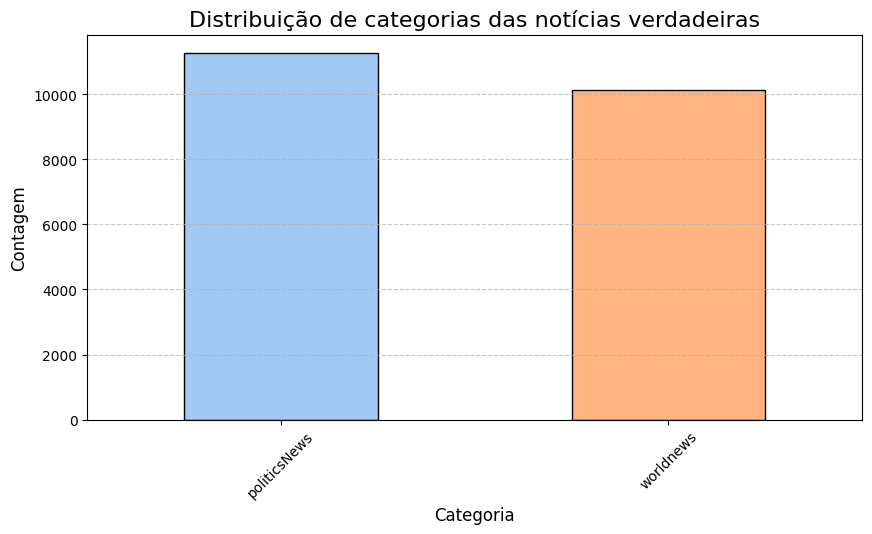

In [15]:
plt.figure(figsize=(10, 5))
colors = sns.color_palette('pastel')
ax = df_true['subject'].value_counts().plot(kind='bar', color=colors, edgecolor='black')
plt.title("Distribuição de categorias das notícias verdadeiras", fontsize=16)
plt.xlabel("Categoria", fontsize=12)
plt.ylabel("Contagem", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Notícias falsas

O gráfico das notícias falsas revela uma diversidade maior de categorias, abrangendo temas relacionados ao governo, aos Estados Unidos e ao espectro político da esquerda

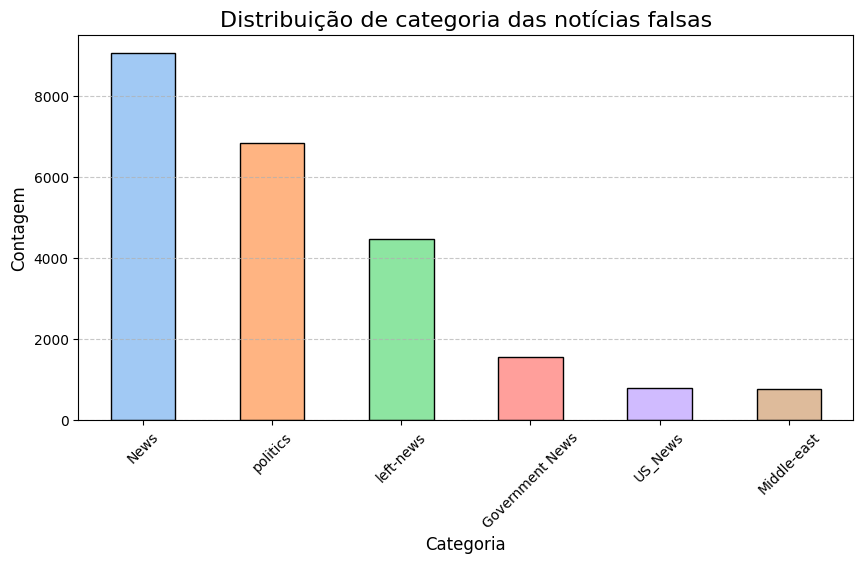

In [16]:
plt.figure(figsize=(10, 5))
colors = sns.color_palette('pastel')
ax = df_false['subject'].value_counts().plot(kind='bar', color=colors, edgecolor='black')
plt.title("Distribuição de categoria das notícias falsas", fontsize=16)
plt.xlabel("Categoria", fontsize=12)
plt.ylabel("Contagem", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Distribuição da variável alvo (status)

Distribuição do *status* para verificar o balanceamento da base de dados.

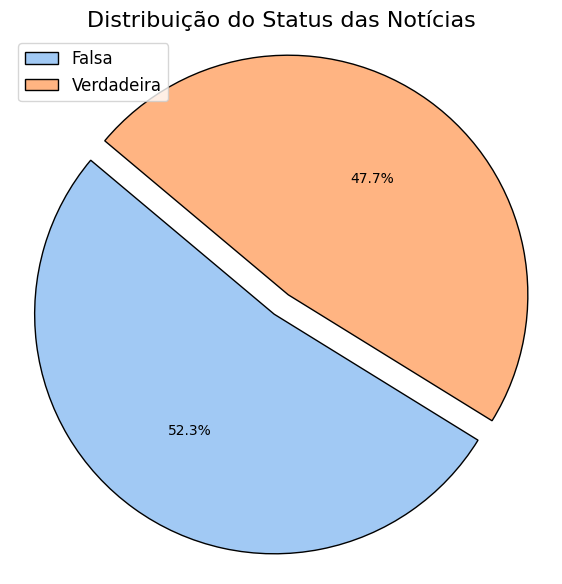

In [18]:
plt.figure(figsize=(7, 7))
colors = sns.color_palette('pastel')
labels = ['Falsa', 'Verdadeira']
sizes = df['status'].value_counts().values

wedges, texts, autotexts = plt.pie(sizes, colors=colors,
  autopct='%1.1f%%', startangle=140,
  explode=(0.1, 0), wedgeprops={'edgecolor': 'black'})

plt.title("Distribuição do Status das Notícias", fontsize=16)
plt.legend(wedges, labels, loc="best", fontsize=12)
plt.axis('equal')
plt.show()

### Comprimento das notícias



#### Média de caractéres por notícia

In [50]:
datasets = {
    "Notícias Verdadeiras - Brutas": df_true['text'],
    "Notícias Falsas - Brutas": df_false['text'],
    "Notícias Verdadeiras - Processadas": df[df['status'] == 1]['text'],
    "Notícias Falsas - Processadas": df[df['status'] == 0]['text']
}

data_summary = []

for name, text_data in datasets.items():
    text_data = text_data.dropna()
    avg_chars = text_data.apply(len).mean()
    data_summary.append([name, f"{avg_chars:.2f} caracteres"])

# Criar tabela estilizada
table = tabulate(data_summary, headers=["Categoria", "Média de Caracteres"], tablefmt="fancy_grid")

print(table)

╒════════════════════════════════════╤═══════════════════════╕
│ Categoria                          │ Média de Caracteres   │
╞════════════════════════════════════╪═══════════════════════╡
│ Notícias Verdadeiras - Brutas      │ 2448.95 caracteres    │
├────────────────────────────────────┼───────────────────────┤
│ Notícias Falsas - Brutas           │ 2642.59 caracteres    │
├────────────────────────────────────┼───────────────────────┤
│ Notícias Verdadeiras - Processadas │ 2372.19 caracteres    │
├────────────────────────────────────┼───────────────────────┤
│ Notícias Falsas - Processadas      │ 2561.46 caracteres    │
╘════════════════════════════════════╧═══════════════════════╛


#### Histograma

Os gráficos apresentados mostram a distribuição do comprimento das notícias (em número de palavras) antes e depois do processamento, com os valores transformados para a escala logarítmica.


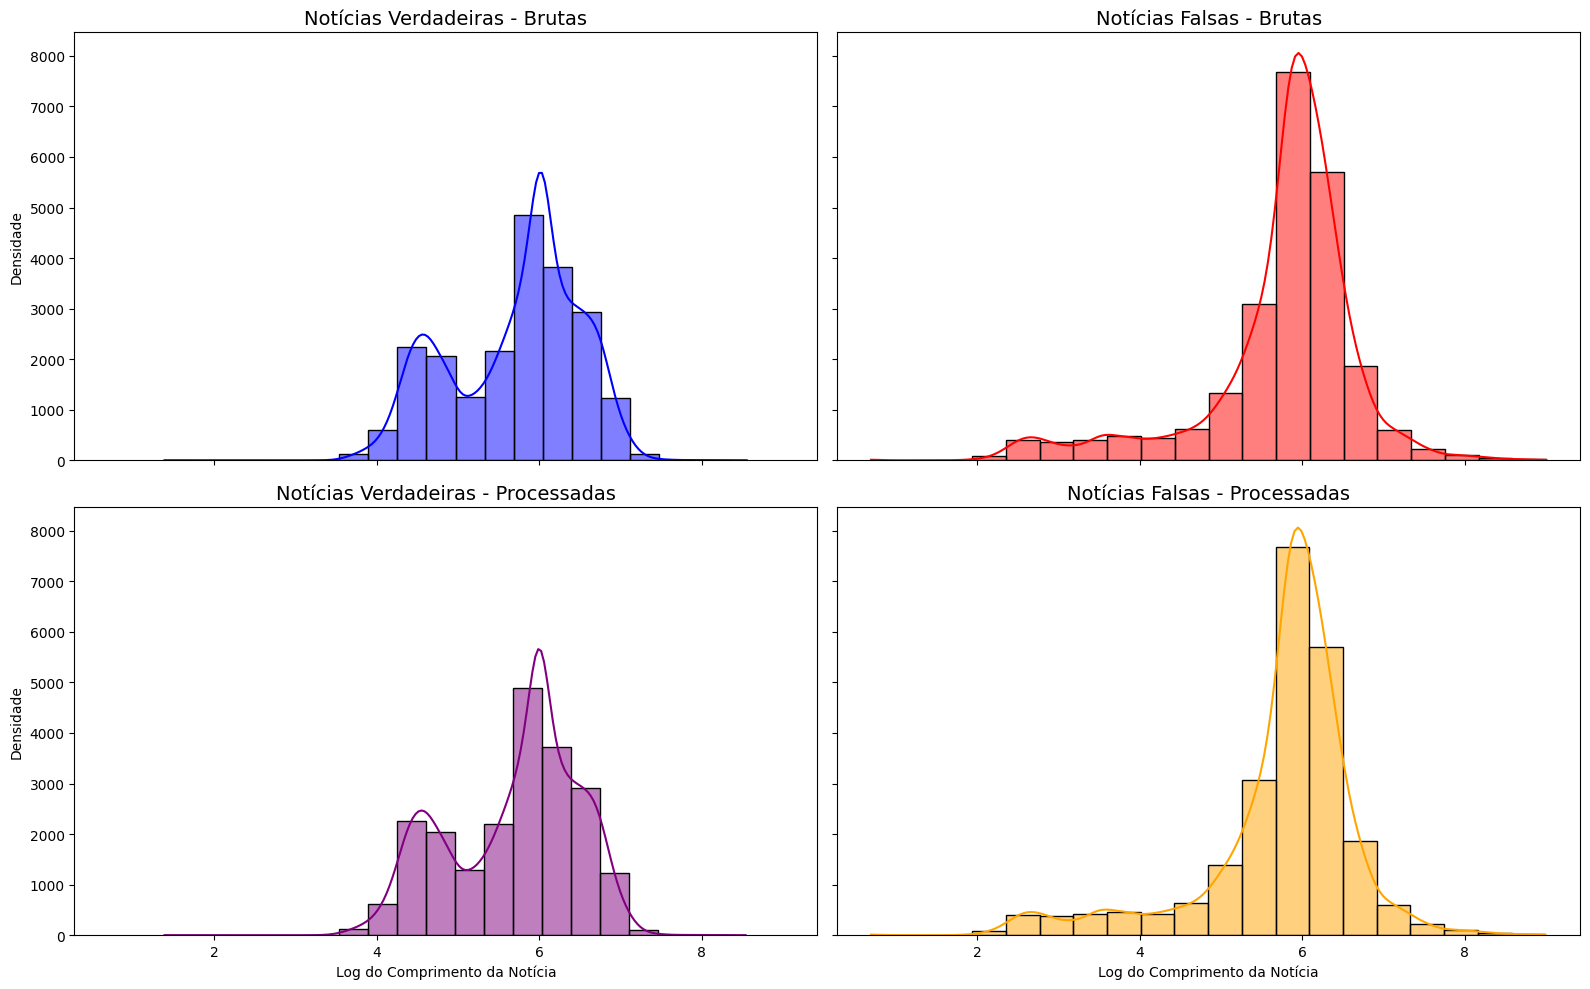

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey=True)

datasets = [
    (df_true['text'], "Notícias Verdadeiras - Brutas", "blue", axes[0, 0]),
    (df_false['text'], "Notícias Falsas - Brutas", "red", axes[0, 1]),
    (df[df['status'] == 1]['text'], "Notícias Verdadeiras - Processadas", "purple", axes[1, 0]),
    (df[df['status'] == 0]['text'], "Notícias Falsas - Processadas", "orange", axes[1, 1])
]

for text_data, title, color, ax in datasets:
  text_data = text_data.dropna()
  text_lengths = [len(news.split()) for news in text_data if len(news.split()) > 0]

  if text_lengths:
      text_lengths = np.log(text_lengths)
      sns.histplot(text_lengths, bins=20, color=color, kde=True, ax=ax)
      ax.set_title(title, fontsize=14)
      ax.set_xlabel("Log do Comprimento da Notícia")
      ax.set_ylabel("Densidade")

plt.tight_layout()
plt.show()

## Nuvem de palavras

### Notícias verdadeiras

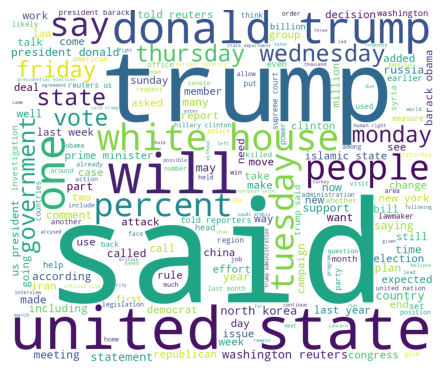

In [34]:
real_text = ' '.join(df[df['status'] == 1]['text'])

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 2)

plt.imshow(WordCloud(width=1200, height=1000, background_color='white').generate(real_text))
plt.axis("off")
plt.show()

### Notícias falsas

(-0.5, 1199.5, 999.5, -0.5)

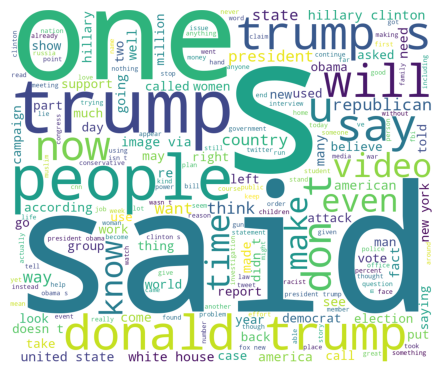

In [35]:
fake_text = ' '.join(df[df['status'] == 0]['text'])

plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=1200, height=1000, background_color='white').generate(fake_text))
plt.axis("off")